Relaxation Dynamics
==========

There are many different methods which can be used to understand the dynamics of a system.
From short timescale events like structural relaxation,
to long timescale events including dynamics.
There are also important degrees of freedom in the rotations which have their own relaxtion timescales.


This is a collection of figures and analysis
for the understanding of relaxation over a series of variables.

All the simulation data is from a set of simulations stored on RDS
in the folder `simulations/2017-09-09-dynamics`.
This set of simulations were all run at a pressure of 13.50. 

## Setup

This imports the modules nessecary for running the code in the rest of this notebook
while also setting up some helper functions to make the rest of the analysis simpler.

In [1]:
from pathlib import Path

import numpy as np
import pandas
import holoviews as hv

from statdyn.analysis import relaxation

import warnings
warnings.filterwarnings("ignore")

hv.extension('matplotlib')
np.seterr(divide='ignore')


def get_temp(fname):
    try:
        return fname.stem.split('-')[3][1:]
    except IndexError:
        return fname.stem.split('-')[2]


def get_relaxations(dframe, factor='rot2'):
    temperatures = []
    relax_constants = []
    relax_errs = []
    for temp, t_frame in dframe.groupby('Temperature'):
        if factor == 'diffusion':
            relax, relax_error = relaxation.diffusion_constant(
                t_frame.time.values,
                t_frame.msd.values
            )
        elif factor == 'struct_msd':
            relax, relax_error = relaxation.threshold_relaxation(
                t_frame.time.values,
                t_frame.msd.values,
                threshold=0.16,
                greater=False
            )
        else:
            relax, err_min, err_max = relaxation.exponential_relaxation(
                t_frame.time.values,
                t_frame[factor].values,
                value_width=0.6
            )
            relax_error = np.abs(err_min) + np.abs(err_max)

        temperatures.append(temp)
        try:
            relax_constants.append(relax)
            relax_errs.append(relax_error)
        except RuntimeError:
            relax_constants.append(np.nan)
            relax_errs.append(np.nan)

    return pandas.DataFrame({'Temperature': temperatures,
                             factor: relax_constants,
                             factor + '_err': relax_errs
                             }, index=temperatures)


### Controlling figure layout

The following options control how all the figures are plotted. 

In [2]:
rc_params = {
    'lines.markersize': 2,
    'legend.markerscale': 2,
    'legend.frameon':  False, 
}
%opts Scatter [logx=True logy=False fig_rcparams=rc_params, labelled=['x']]
%opts NdOverlay [legend_position='right', fig_rcparams=rc_params]
%opts HLine (color='k')
%output fig='pdf' dpi=150 size=120

### Import Data

This reads all the data from disk,
creating a pandas DataFrame and
a Holoviews Table for analysis and plotting of the data. 

In [3]:
source_directory = '/home/malcolm/rds/simulations/2017-09-09-dynamics/dynamics/'

dataframes = []
for f in Path(source_directory).glob('trajectory*.hdf5'):
    df = pandas.read_hdf(f, 'dynamics')
    # Average over all initial configurations 
    df = df.groupby(['time']).mean()
    # Extract simulation temperature from filename
    df['Temperature'] = float(get_temp(Path(f)))
    # Drop first row with zero values -> causes errors in log plots 
    df.drop(0, inplace=True)
    # Don't use the time as the index -> required as column for plotting
    df.reset_index(inplace=True)
    dataframes.append(df)

src = pandas.concat(dataframes)

The available temperatures for plotting are listed below.
To make the visualisations of time dependent properties less cluttered 
only a subset of the temperatures will be used for plotting.
For relaxation timescales all the temperatrues will be used.
This list of temperatures for plotting can be modified by changing the plot_temperatures variable.

In [4]:
np.sort(src['Temperature'].unique())

array([ 1.2 ,  1.25,  1.3 ,  1.31,  1.32,  1.33,  1.34,  1.35,  1.36,
        1.37,  1.38,  1.39,  1.4 ,  1.42,  1.43,  1.44,  1.45,  1.46,
        1.48,  1.5 ,  1.55,  1.6 ,  1.7 ,  1.8 ,  2.  ,  2.5 ,  3.  ,
        3.5 ,  4.  ,  5.  ])

In [5]:
plot_temperatures = [1.3, 1.35, 1.40, 1.45, 1.5, 1.55, 1.6, 1.7, 1.8, 2, 2.5, 3., 4., 5.]

In [6]:
src_df = src.query('Temperature in @plot_temperatures')
src_hv = hv.Table(src_df, kdims=[('time', 't'), ('Temperature', 'T')])

Diffusion
--------

Generating the figures for diffusive relaxation of molecules. Lines are indications of fit, where $D t$ is the function that is defining the fit. The parameter `D` is then used as the diffusion constant in the following figure.

:NdOverlay   [Temperature]
   :Scatter   [time]   (msd)
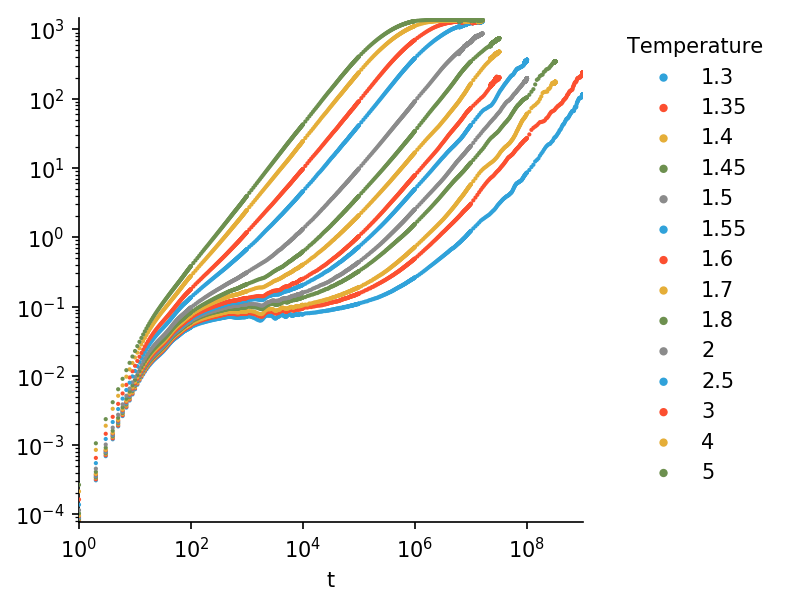

In [7]:
%%opts Scatter [logy=True]
src_hv.to(hv.Scatter, 'time', 'msd').overlay()

Rotational Relaxation R1
--------------------

The rotational realxation $R_1$ is the value of the function 
$$R_1(t) = \langle \hat{\mathbf{e}}(0) \cdot \hat{\mathbf{e}}(t) \rangle$$
where the average is over all molecules and starting configurations.

:NdOverlay   [Temperature]
   :Scatter   [time]   (rot1)
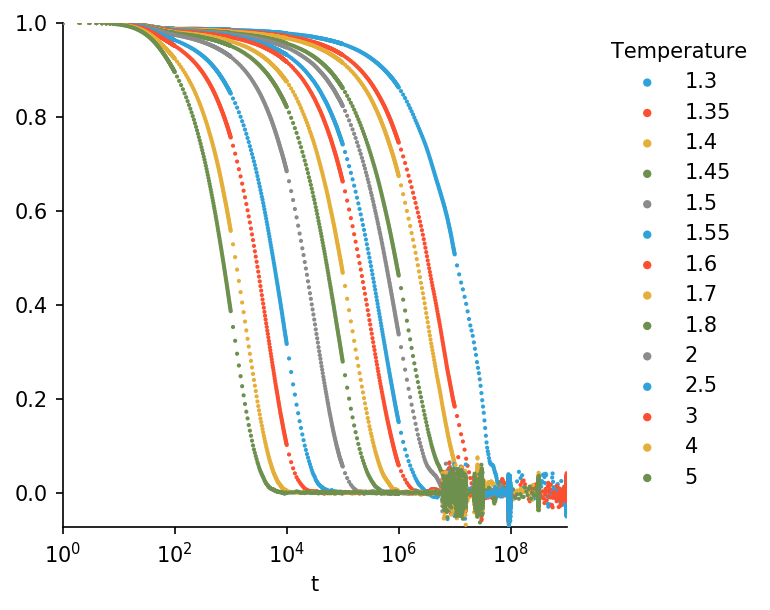

In [8]:
src_hv.to(hv.Scatter, 'time', 'rot1').overlay()

Rotational Relaxation R2
--------------------

This is the second order relaxation function,
given by;
$$R_2(t) = \langle 2[ \hat{\mathbf{e}}(0) \cdot \hat{\mathbf{e}}(t)]^2 - 1 \rangle$$
where the value is averaged over all molecules and starting configurations. 

:NdOverlay   [Temperature]
   :Scatter   [time]   (rot2)
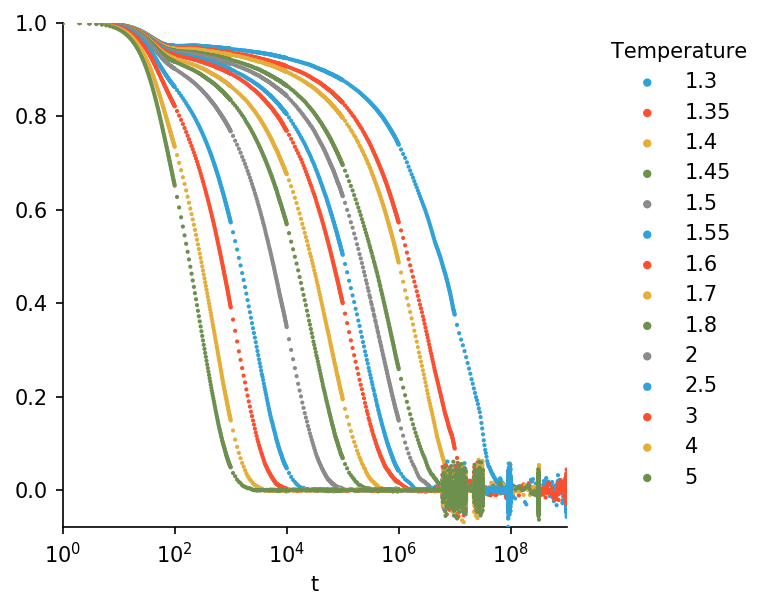

In [9]:
src_hv.to(hv.Scatter, 'time', 'rot2').overlay()

Structural Relaxation
--------------------

This is the fraction of particles which have moved a distance of 0.3 from their inital position.

:NdOverlay   [Temperature]
   :Scatter   [time]   (struct)
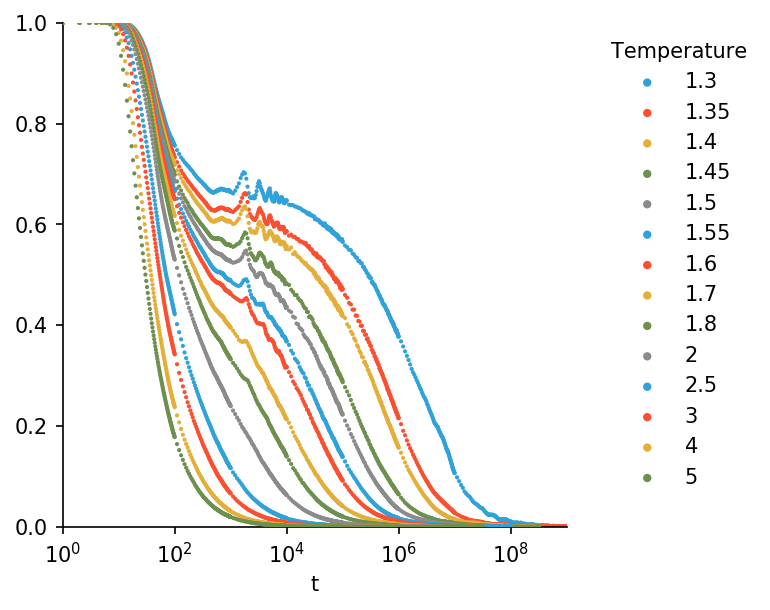

In [10]:
src_hv.to(hv.Scatter, 'time', 'struct').overlay()

Summary Values
========

The values calculated below summarise the above information,
providing a method of investigating temperature dependence of these properties. 

In [11]:
# Compute diffusion constant
summary_vals = get_relaxations(src, 'diffusion')

# Compute inverse diffusion constant -> comparable to a relaxation time
summary_vals['inv_diffusion'] = 1./summary_vals.diffusion
summary_vals['inv_diffusion_err'] = (
    summary_vals.inv_diffusion - 
    1./(summary_vals.diffusion - summary_vals.diffusion_err))

# Compute rotational relaxation times
summary_vals = get_relaxations(src, 'rot1').combine_first(summary_vals)
summary_vals = get_relaxations(src, 'rot2').combine_first(summary_vals)

# Compute structural relaxtion times
summary_vals = get_relaxations(src, 'struct').combine_first(summary_vals)
summary_vals = get_relaxations(src, 'com_struct').combine_first(summary_vals)
summary_vals = get_relaxations(src, 'struct_msd').combine_first(summary_vals)

# Compute inverse temperature -> for using as axis 
summary_vals['inv_temp'] = 1./summary_vals['Temperature']

summary_hv = hv.Table(summary_vals, kdims=[('inv_temp', '1/T')])

In [12]:
rc_params['lines.markersize'] = 6
rc_params['legend.markerscale'] = 1
%opts Scatter [logx=False logy=True, fig_rcparams=rc_params]
%opts Overlay [legend_position='top_left' fig_rcparams=rc_params]

:Overlay
   .Scatter.A_1_over_D :Scatter   [inv_temp]   (inv_diffusion)
   .ErrorBars.I        :ErrorBars   [inv_temp]   (inv_diffusion,inv_diffusion_err)
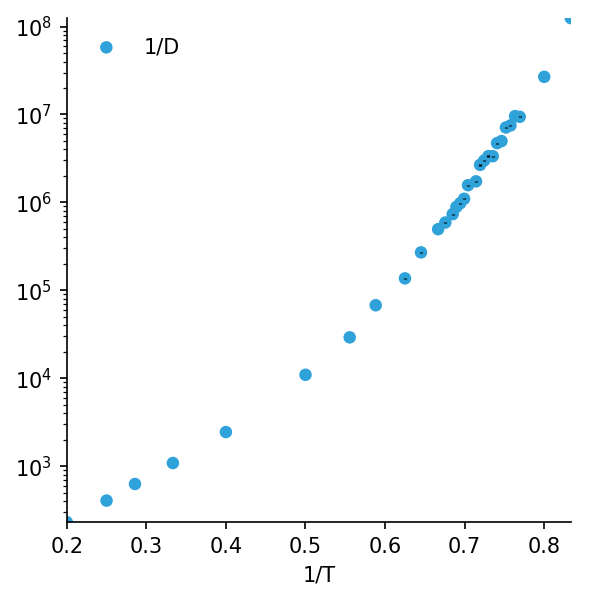

In [13]:
inv_diff = hv.Scatter(summary_hv, vdims=[('inv_diffusion', ' ')], label='1/D')
inv_diff *= hv.ErrorBars(summary_hv, vdims=['inv_diffusion', 'inv_diffusion_err'])
    
inv_diff

:Overlay
   .Scatter.Reverse_over_tau_left_curly_bracket_R1_right_curly_bracket :Scatter   [inv_temp]   (rot1)
   .ErrorBars.I                                                        :ErrorBars   [inv_temp]   (rot1,rot1_err)
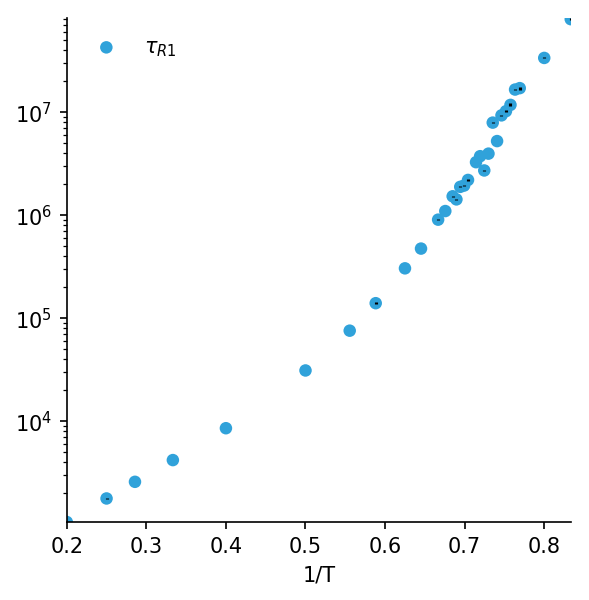

In [14]:
tauR1 = hv.Scatter(summary_hv, vdims=[('rot1', ' ')], label=r'$\tau_{R1}$')
tauR1 *= hv.ErrorBars(summary_hv, vdims=['rot1', 'rot1_err'])
tauR1

:Overlay
   .Scatter.Reverse_over_tau_left_curly_bracket_R2_right_curly_bracket :Scatter   [inv_temp]   (rot2)
   .ErrorBars.I                                                        :ErrorBars   [inv_temp]   (rot2,rot2_err)
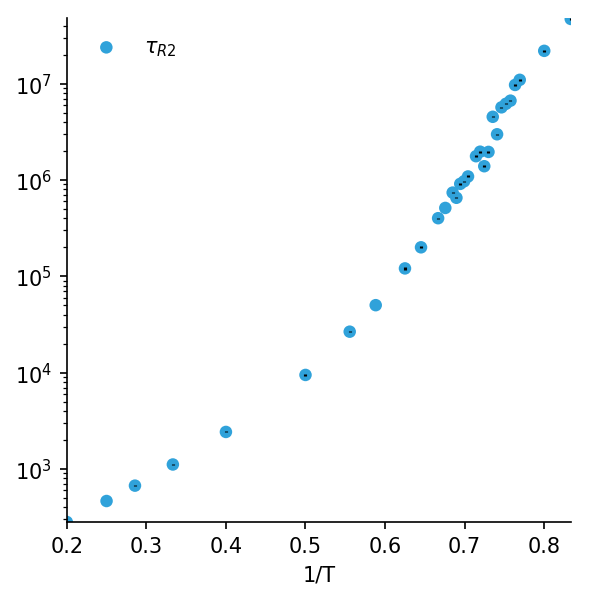

In [15]:
tauR2 = hv.Scatter(summary_hv,  vdims=[('rot2', ' ')], label=r'$\tau_{R2}$')
tauR2 *= hv.ErrorBars(summary_hv, vdims=['rot2', 'rot2_err'])
tauR2

:Overlay
   .Scatter.Reverse_over_tau_s :Scatter   [inv_temp]   (struct)
   .ErrorBars.I                :ErrorBars   [inv_temp]   (struct,struct_err)
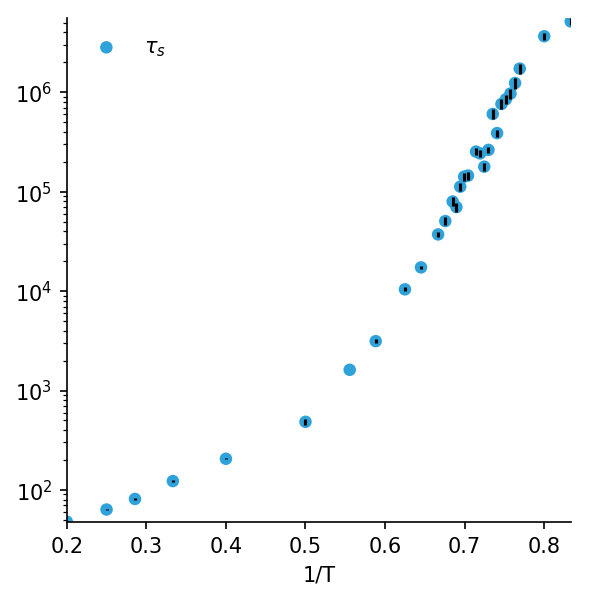

In [16]:
struct = hv.Scatter(summary_hv,  vdims=[('struct', ' ')], label=r'$\tau_s$')
struct *= hv.ErrorBars(summary_hv, vdims=['struct', 'struct_err'])

struct_msd = hv.Scatter(summary_hv, vdims=['struct_msd'], label='τ_msd')
struct_com = hv.Scatter(summary_hv, vdims=['com_struct'], label='τ_Scom')
struct

:Overlay
   .Scatter.A_1_over_D                                                 :Scatter   [inv_temp]   (inv_diffusion)
   .ErrorBars.I                                                        :ErrorBars   [inv_temp]   (inv_diffusion,inv_diffusion_err)
   .Scatter.Reverse_over_tau_s                                         :Scatter   [inv_temp]   (struct)
   .ErrorBars.II                                                       :ErrorBars   [inv_temp]   (struct,struct_err)
   .Scatter.Reverse_over_tau_left_curly_bracket_R1_right_curly_bracket :Scatter   [inv_temp]   (rot1)
   .ErrorBars.III                                                      :ErrorBars   [inv_temp]   (rot1,rot1_err)
   .Scatter.Reverse_over_tau_left_curly_bracket_R2_right_curly_bracket :Scatter   [inv_temp]   (rot2)
   .ErrorBars.IV                                                       :ErrorBars   [inv_temp]   (rot2,rot2_err)
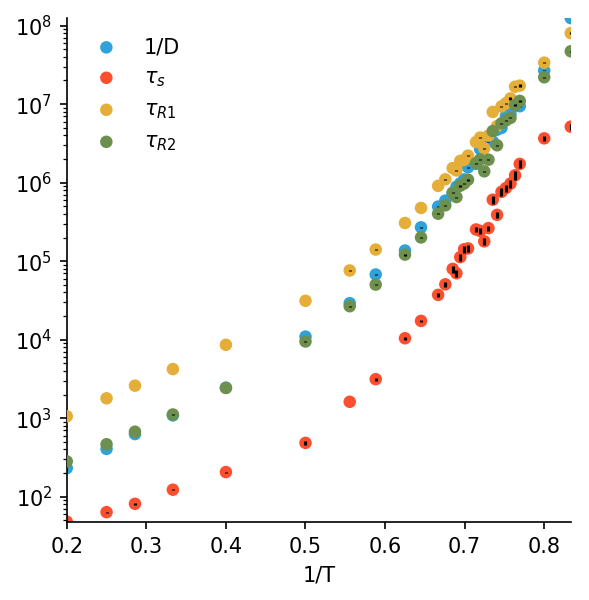

In [17]:
inv_diff * struct * tauR1 * tauR2

:Overlay
   .Scatter.Reverse_over_tau_left_curly_bracket_R2_right_curly_bracket :Scatter   [struct]   (rot2)
   .Scatter.A_1_over_D                                                 :Scatter   [struct]   (inv_diffusion)
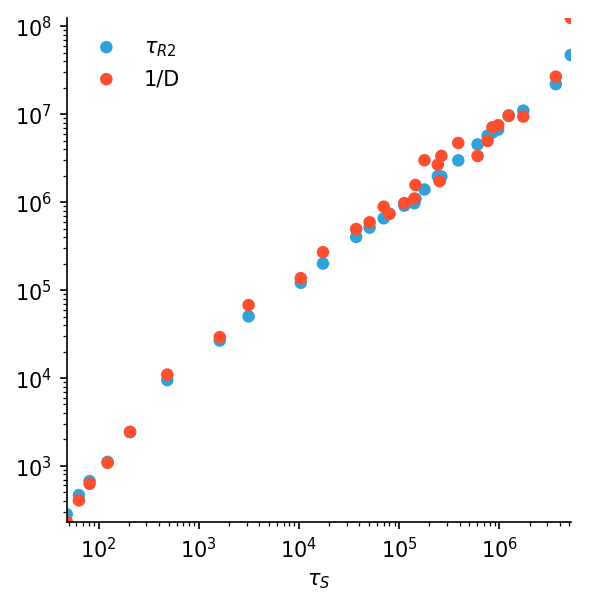

In [18]:
%%opts Scatter [logx=True logy=True]
(hv.Scatter(summary_vals, 
            kdims=[('struct', r'$\tau_S$')], 
            vdims=[('rot2')], 
            label=r'$\tau_{R2}$') *
 hv.Scatter(summary_vals, 
            kdims=['struct'], 
            vdims=[('inv_diffusion', ' ')], 
            label='1/D')
)

In [19]:
values = pandas.DataFrame({
    'Temperature': summary_vals.Temperature, 
    'r1r2': summary_vals.rot1/summary_vals.rot2,
    'Dr1T': summary_vals.diffusion*summary_vals.rot1/summary_vals.Temperature,
    'Dr2T': summary_vals.diffusion*summary_vals.rot2/summary_vals.Temperature,
    'DsT': summary_vals.diffusion*summary_vals.struct/summary_vals.Temperature,
    'Dr1': summary_vals.diffusion*summary_vals.rot1,
    'Dr2': summary_vals.diffusion*summary_vals.rot2,
})

:Overlay
   .Scatter.D_reverse_over_tau_left_curly_bracket_2_right_curly_bracket_over_T                                                       :Scatter   [x]   (y)
   .Scatter.D_reverse_over_tau_left_curly_bracket_s_right_curly_bracket_over_T                                                       :Scatter   [x]   (y)
   .Scatter.Reverse_over_tau_left_curly_bracket_1_right_curly_bracket_over_reverse_over_tau_left_curly_bracket_2_right_curly_bracket :Scatter   [x]   (y)
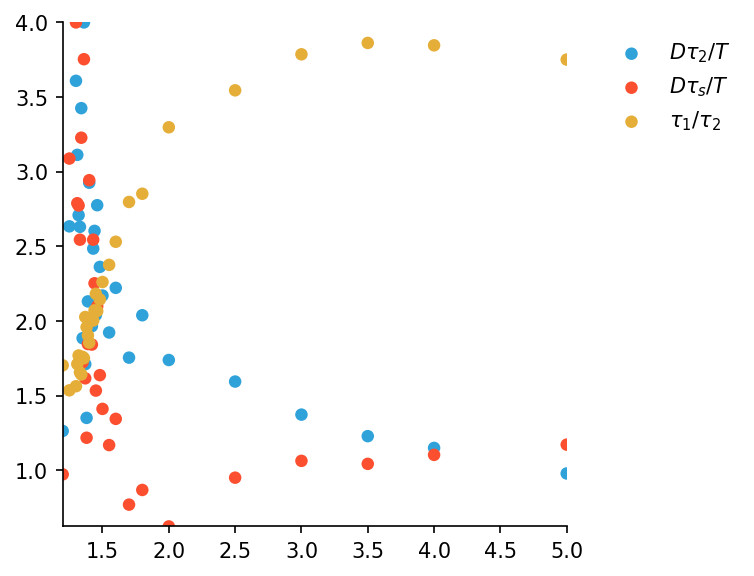

In [20]:
%%opts Scatter [logx=False logy=False labelled=[]]
%%opts Overlay [legend_position='right']
p = (
hv.Scatter((values.Temperature, 4*values.Dr2T/values.Dr2T.max()), label=r'$D\tau_{2}/T$')
* hv.Scatter((values.Temperature, 4*values.DsT/values.DsT.max()), label=r'$D\tau_{s}/T$')
* hv.Scatter((values.Temperature, values.r1r2), label=r'$\tau_{1}/\tau_{2}$')
)

p

In [21]:
summary_vals.to_hdf(Path(source_directory) / 'dynamics.hdf5', 'relaxations') 